# 5 Slepian Symmetry

In [1]:
using SpecialFunctions  # for besselj
using QuadGK            # for numerical integration quadgk
using Printf
using Plots
using GenericLinearAlgebra  # High-precision eigenvalue solver
import LinearAlgebra
using SparseArrays
using FastGaussQuadrature

function printb(condition::Bool)
    if condition
        println("\033[32mTrue\033[0m")
    else
        println("\033[31mFalse\n\033[0m")
    end
end

printb (generic function with 1 method)

## Bessel Function

Bessel Function of the First Kind, J_m(k), for integer m 

J_m(k) = sum_{n=0}^{∞} [ (-1)^n / (n! (m+n)!) ] * (k/2)^(m+2n) 

Also satisfies the symmetry condition J_{-m}(k) = (-1)^m J_m(k).\\

In [2]:
"""
    identity_sum_J(k, M)

Compute the partial sum S_M = J_0^2(k) + 2∑_{m=1 to M} J_m^2(k)
and compare it to 1. As M -> ∞, we expect S_M -> 1.
"""
function identity_sum_J(k::Real, M::Integer)
    term0 = besselj(0, k)^2
    # sum over m = 1..M
    term_sum = sum( besselj(m, k)^2 for m in 1:M )
    return term0 + 2*term_sum
end

"""
    bessel_expansion_2D(k, r, rprime, theta, thetaprime, M)

Compute the partial sum of 
  J_0(k||x - x'||)  ≈  J_0(kr) J_0(kr') + 2∑_{m=1..M} J_m(kr) J_m(kr') cos[m(θ - θ')].
Returns a tuple (lhs, rhs_M):

- lhs = J_0(k * distance(x, x'))
- rhs_M = partial sum up to m = M.
  
As M grows, rhs_M should converge to lhs.
"""
function bessel_expansion_2D(k::Real,
                             r::Real, rprime::Real,
                             theta::Real, thetaprime::Real,
                             M::Integer)
    # LHS: exact Bessel function on the distance
    # distance in Cartesian: x   = (r cosθ,   r sinθ)
    #                       x'  = (r'cosθ', r' sinθ')
    # norm(x - x') = sqrt(r^2 + r'^2 - 2 r r' cos(θ - θ'))
    dist = sqrt(r^2 + rprime^2 - 2r*rprime*cos(theta - thetaprime))
    lhs = besselj(0, k * dist)
    
    # RHS: partial sum
    rhs0 = besselj(0, k*r) * besselj(0, k*rprime)
    rhs_sum = 0.0
    for m in 1:M
        rhs_sum += besselj(m, k*r)*besselj(m, k*rprime)*cos(m*(theta - thetaprime))
    end
    rhs_M = rhs0 + 2*rhs_sum
    
    return lhs, rhs_M
end

bessel_expansion_2D

### Sanity check for Bessel Function

In [3]:
"""
    check_symmetry(m, k)

Check numerically that J_{-m}(k) = (-1)^m * J_m(k).
Returns the difference left - right for a sanity check.
"""
function check_symmetry(m::Integer, k::Real)
    left  = besselj(-m, k)
    right = (-1)^m * besselj(m, k)
    return left - right
end

println("Check symmetry condition J_{-m}(k) = (-1)^m J_m(k):")
for m in -2:2
    diff = check_symmetry(m, 5.0)
    print("m = $m, symmetry: ")
    printb(isapprox(0,diff))
end
println()

# 2) Check the identity 1 = J_0^2(k) + 2∑_{m=1 to ∞} J_m^2(k)
# We'll do a partial sum up to M = 20 for some k values:
kvals = [0.0, 1.0, 5.0, 10.0]
M = 20
println("Check the sum identity S_M = J_0^2(k) + 2∑_{m=1..M} J_m^2(k), expecting it → 1")
for k in kvals
    s_M = identity_sum_J(k, M)
    print("k = $k, M = $M, partial sum = $s_M ")
    printb(isapprox(1.0, s_M))
end
println()
# 3) Check the 2D expansion
# Suppose r=1, r'=2, theta=0.1 rad, theta'=1.0 rad, k=3. We'll do partial sums up to M=10:
r, rprime = 1.0, 2.0
theta, thetaprime = 0.1, 1.0
k = 3.0
M = 20
lhs, rhs_M = bessel_expansion_2D(k, r, rprime, theta, thetaprime, M)
print("Check 2D expansion J_0(k||x-x'||) with M=$M ") 
printb(isapprox(lhs, rhs_M))

Check symmetry condition J_{-m}(k) = (-1)^m J_m(k):
m = -2, symmetry: True
m = -1, symmetry: True
m = 0, symmetry: True
m = 1, symmetry: True
m = 2, symmetry: True

Check the sum identity S_M = J_0^2(k) + 2∑_{m=1..M} J_m^2(k), expecting it → 1
k = 0.0, M = 20, partial sum = 1.0 True
k = 1.0, M = 20, partial sum = 1.0 True
k = 5.0, M = 20, partial sum = 0.9999999999999999 True
k = 10.0, M = 20, partial sum = 0.9999999999820721 True

Check 2D expansion J_0(k||x-x'||) with M=20 True


### Equation 50, 51 and 52 

In [4]:
# ---------------------------------------------------------------
# 50) J0(k) via integral definition
#    J0(k) = (2π)^(-1) * ∫[0..2π] e^{ i k cos(θ) } dθ
#
#    Since J0(k) is real, we can integrate cos(k cos θ) instead
#    because  real( e^{ i x } ) = cos(x).
# ---------------------------------------------------------------
function J0_def(k::Real)
    f(θ) = cos(k * cos(θ))   # real part of e^{ i k cos(θ) }
    val, err = quadgk(f, 0, 2π)
    return val / (2π)
end

# ---------------------------------------------------------------
# 50) J1(k) via integral definition
#    J1(k) = (1/k) * ∫[0..k] [ k' J0(k') ] dk'
# ---------------------------------------------------------------
function J1_def(k::Real)
    # For k=0, define J1(0) = 0 by continuity.
    if k == 0
        return 0.0
    end
    
    f(kp) = kp * besselj(0, kp)   # besselj(0, kp) is J0(k')
    val, err = quadgk(f, 0, k)
    return (1/k) * val
end

# ---------------------------------------------------------------
# 51) J_(1/2)(k) closed form
#    J_{1/2}(k) = sqrt(2/(π k)) * sin(k)
# ---------------------------------------------------------------
function J_half_def(k::Real)
    return sqrt(2/(π*k)) * sin(k)
end

# ---------------------------------------------------------------
# 52) Check derivative identity:
#    d/dk [ k J1(k) ] = k J0(k).
#
# We'll verify numerically by finite differences:
#    ( k J1(k) )' ≈ [ k+δ * J1(k+δ) - k * J1(k) ] / δ
# ---------------------------------------------------------------
function check_derivative_identity(k::Real; δ=1e-6)
    # left side: finite difference approximation of d/dk [k J1(k)]
    left = ((k+δ)*besselj(1, k+δ) - k*besselj(1, k)) / δ
    
    # right side: k J0(k)
    right = k * besselj(0, k)
    
    return left - right  # difference should be ~ 0
end

# ---------------------------------------------------------------
# 52) Limits
#    i)   lim_{k -> 0} [ J1(k)/k ] = 0.5
#    ii)  lim_{k -> 0} [ J_m(k)/sqrt(k) ] = 0   (for m>0)
#
# We'll just show approximate evaluations near k=0.
# ---------------------------------------------------------------

function limit_J1_over_k(ε::Real=1e-8)
    return besselj(1, ε)/ε
end

function limit_Jm_over_sqrt_k(m::Integer; ε=1e-8)
    return besselj(m, ε)/sqrt(ε)
end


limit_Jm_over_sqrt_k (generic function with 1 method)

### Sanity check for eq 50, 51, 52

In [5]:
println("=== 1) Compare J0 via integral with built-in besselj(0, k) ===")
for k in [0.0, 1.0, 5.0]
    j0_int = J0_def(k)
    j0_sf  = besselj(0, k)
    @printf("k = %4.1f | Integral-based J0_def(k) = % .6f | besselj(0,k) = % .6f | Diff = % .6e ",
            k, j0_int, j0_sf, j0_int - j0_sf)
    printb(isapprox(j0_int, j0_sf))
end
println()

println("=== 2) Compare J1 via integral with built-in besselj(1, k) ===")
for k in [0.0, 1.0, 5.0]
    j1_int = J1_def(k)
    j1_sf  = besselj(1, k)
    @printf("k = %4.1f | Integral-based J1_def(k) = % .6f | besselj(1,k) = % .6f | Diff = % .6e ",
            k, j1_int, j1_sf, j1_int - j1_sf)
    printb(isapprox(j1_int, j1_sf))
end
println()

println("=== 3) J_(1/2)(k) = √[2/(πk)] sin(k) ===")
for k in [0.5, 1.0, 3.0, 5.0]
    j_half_exact = J_half_def(k)
    # We can also compare with besselj(0.5, k) from SpecialFunctions
    j_half_sf    = besselj(0.5, k)
    @printf("k = %4.1f | J_{1/2} from formula = % .6f | besselj(0.5,k) = % .6f | Diff = % .6e ",
            k, j_half_exact, j_half_sf, j_half_exact - j_half_sf)
    printb(isapprox(j_half_exact, j_half_sf))
end
println()

println("=== 4) Check derivative identity: d/dk[k J1(k)] ≟ k J0(k) ===")
for k in [0.1, 1.0, 5.0]
    diff = check_derivative_identity(k)
    @printf("k = %4.1f | difference ≈ % .6e\n", k, diff)
end
println()

println("=== 5) Limits as k -> 0 ===")
# (i)  J1(k)/k -> 0.5
val1 = limit_J1_over_k()
@printf("J1(k)/k at k=1e-8 ≈ %g  (expected ~ 0.5)\n", val1)

# (ii) For m>0, J_m(k)/√k -> 0
m_test = 1
val2 = limit_Jm_over_sqrt_k(m_test)
@printf("J%d(k)/√k at k=1e-8 ≈ %g  (expected ~ 0)\n", m_test, val2)

=== 1) Compare J0 via integral with built-in besselj(0, k) ===
k =  0.0 | Integral-based J0_def(k) =  1.000000 | besselj(0,k) =  1.000000 | Diff =  0.000000e+00 True
k =  1.0 | Integral-based J0_def(k) =  0.765198 | besselj(0,k) =  0.765198 | Diff =  1.110223e-16 True
k =  5.0 | Integral-based J0_def(k) = -0.177597 | besselj(0,k) = -0.177597 | Diff = -1.387779e-16 True

=== 2) Compare J1 via integral with built-in besselj(1, k) ===
k =  0.0 | Integral-based J1_def(k) =  0.000000 | besselj(1,k) =  0.000000 | Diff =  0.000000e+00 True
k =  1.0 | Integral-based J1_def(k) =  0.440051 | besselj(1,k) =  0.440051 | Diff =  0.000000e+00 True
k =  5.0 | Integral-based J1_def(k) = -0.327579 | besselj(1,k) = -0.327579 | Diff =  0.000000e+00 True

=== 3) J_(1/2)(k) = √[2/(πk)] sin(k) ===
k =  0.5 | J_{1/2} from formula =  0.540974 | besselj(0.5,k) =  0.540974 | Diff = -5.551115e-16 True
k =  1.0 | J_{1/2} from formula =  0.671397 | besselj(0.5,k) =  0.671397 | Diff = -6.661338e-16 True
k =  3.0 | 

## 5.1 - Circular Bandlimitation

### Kernel:- D(x, x') for k = 1, 2D

In [8]:
"""
    D(x, xprime)
    
    Computes D(x, x') = (K J_1(K ||x - x'||)) / (2π ||x - x'||),
    where K = 1, and ||x - x'|| is the Euclidean distance between x and x' for 2 dimensions
"""
function D(x::Tuple{Real, Real}, xprime::Tuple{Real, Real})
    # Extract coordinates
    x1, x2 = x
    x1p, x2p = xprime
    K = 1  
    # Euclidean distance ||x - x'||
    distance = LinearAlgebra.norm([x1 - x1p, x2 - x2p])
    
    # Handle edge case where x == x' (distance = 0)
    if distance == 0
        # error("D(x, x') is undefined for x == x' (division by zero).")
        # limit K^2 / (4π)
        return (K^2)/(4π)
    end
    
    # Compute D(x, x')
    return (K * J1_def(K * distance)) / (2π * distance)
end


D

### Sanity Check for D(x,x') ≟ D(x',x) ≟ D(||x-x'||)

In [9]:
x1 = (rand(),rand())
x2 = (rand(),rand())
# Compute D(x, x'), D(x', x), and D(||x - x'||)
D1 = D(x1, x2)
D2 = D(x2, x1)
D3 = D(x1, x1.-1e-16)
cnst = 1/(4*pi)
println("x1 = $x1")
println("x2 = $x2")
println("D(x, x') = $D1")
println("D(x', x) = $D2")
print(" - Symmetry: D(x, x') ≟ D(x', x) \t\t\t")
printb(isapprox(D1, D2))
print(" - constant dependence: D(x, x) ≟ K^2/(4pi) \n\t    $D3 ≟ $cnst \t")
printb(isapprox(D3, cnst))

x1 = (0.8242553898148736, 0.42543618269474726)
x2 = (0.5789462188425012, 0.741821903662923)
D(x, x') = 0.07799378313613026
D(x', x) = 0.07799378313613026
 - Symmetry: D(x, x') ≟ D(x', x) 			True
 - constant dependence: D(x, x) ≟ K^2/(4pi) 
	    0.07957747154594767 ≟ 0.07957747154594767 	True


### D(x, x') for n dimensions 

In [10]:
"""
    Dn(x, xprime, K, n)
    
    Computes D(x, x') = (K J_1(K ||x - x'||)) / (2π ||x - x'||),
    where ||x - x'|| is the Euclidean distance between x and x' for n dimensions
"""
function Dn(x::Tuple{Real, Real, Real}, xprime::Tuple{Real, Real, Real}, K::Int, n::Int)
    # Extract coordinates
    x1, x2, x3p = x
    x1p, x2p, x3p = xprime
    
    # Euclidean distance ||x - x'||
    distance = norm([x1 - x1p, x2 - x2p, x3 - x3p])
    
    # Handle edge case where x == x' (distance = 0)
    if distance == 0
        error("D(x, x') is undefined for x == x' (division by zero).")
    end
    
    # Compute D(x, x')
    return ((K^(n/2)) * J(n/2, K * distance)) / ((2π * distance)^(n/2))
end

Dn

In [11]:

# ================================================
#    Numerical Approximation of ∫ D(x,x) dx
#    over a rectangular region [xL, xU] x [yL, yU]
# ================================================

function approximate_integral_D_self(xL::Real, xU::Real, yL::Real, yU::Real, eN::Int; K::Real=1)
    """
    approximate_integral_D_self(xL, xU, yL, yU, eN; K=1)

    Approximate 
        ∫[xL..xU, yL..yU] D(x, x) dx
    using a uniform grid of size eN x eN.
    """
    # 1) Build grid
    xs = range(xL, xU, length=eN)
    ys = range(yL, yU, length=eN)
    Δx = (xU - xL)/(eN - 1)
    Δy = (yU - yL)/(eN - 1)
    cell_area = Δx * Δy

    # 2) Sum up D(x_i, x_i) for all grid points
    sum_val = 0.0
    for iy in 1:eN
        for ix in 1:eN
            x = (xs[ix], ys[iy])
            sum_val += D(x, x)
        end
    end

    # 3) Multiply by the cell area to approximate the integral
    return sum_val * cell_area
end


function find_area_and_shannon(xL::Real, xU::Real, yL::Real, yU::Real, eN::Int; K::Real=1)
    """
    find_area_and_shannon(xL, xU, yL, yU, eN; K=1)
    
    1) Approximates the integral 
       N^{2D} = ∫ D(x, x) dx
       over [xL, xU] x [yL, yU] using a eN x eN grid.
    2) Solves for the area A from
       N^{2D} = (K^2 A)/(4π).
    
    Returns (N2D, A).
    """
    # a) Numerical approximation of integral => N^{2D}
    N2D_approx = approximate_integral_D_self(xL, xU, yL, yU, eN; K=K)

    # b) Solve for A via  N^{2D} = (K^2 * A)/(4π)
    #    => A = (4π / K^2) * N^{2D}
    A_calc = (4π / (K^2)) * N2D_approx

    return N2D_approx, A_calc
end


find_area_and_shannon (generic function with 1 method)

In [12]:
xL, xU = -5,5
yL, yU = -5,5
eN     = 1001   # number of points in each dimension
K      = 1.0     # wavenumber

N2D_est, A_est = find_area_and_shannon(xL, xU, yL, yU, eN; K=K)

println("Computed Shannon number  N^{2D} = $N2D_est")
println("Solved-for area A = $A_est  (expected ~ 4 if [-1,1] x [-1,1])")
print("Check ratio:  (K^2 * A_est)/(4π) ≟ N^{2D} ") 
printb(isapprox(N2D_est, (K^2 * A_est)/(4π)))

Computed Shannon number  N^{2D} = 7.973670606655335
Solved-for area A = 100.20010000005308  (expected ~ 4 if [-1,1] x [-1,1])
Check ratio:  (K^2 * A_est)/(4π) ≟ N^{2D} True


## 5.2: Scaling analysis I

Number of points inside the circle of radius 2 = 1876.
Largest 100 eigenvalues (by magnitude) from the discrete operator:
Number of points inside the circle of radius 2 = 1876.


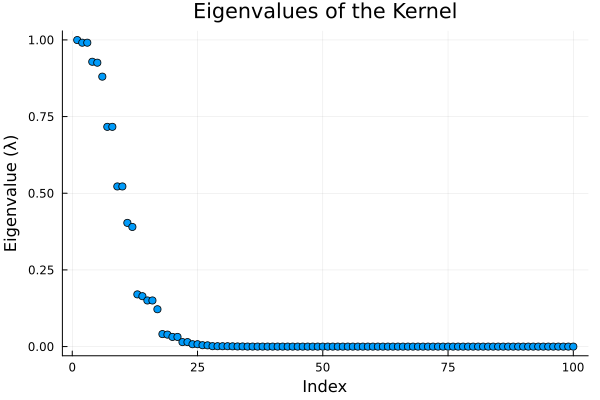

In [15]:
# --------------------------------------------------------
# 1) Define the kernel D(ξ, ξ'), for a given N^{2D}.
#    D(ξ, ξ') = [ sqrt(N^{2D}) * J1( sqrt(N^{2D}) * r ) ] / [ 2π * r ]
#    where r = ||ξ - ξ'|| in R^2.
#
#    For r -> 0, we use the limit:
#        J1(z) ~ z/2  => D(ξ, ξ) ~ [ N^{2D} / 2 ] / [2π] = N^{2D} / (4π).
# --------------------------------------------------------
function D_kernel(xi::Tuple{Real,Real}, xip::Tuple{Real,Real}, N2D::Real)
    # Euclidean distance
    dx = xi[1] - xip[1]
    dy = xi[2] - xip[2]
    r = sqrt(dx*dx + dy*dy)

    # handle r ~ 0 using limiting value
    if r == 0
        # limit as r->0:  D(ξ, ξ) = N^{2D}/(4π)
        return N2D/(4π)
    else
        alpha = sqrt(N2D) * r
        return ( sqrt(N2D) * besselj(1, alpha ) ) / ( 2π * r )
    end
end

# --------------------------------------------------------
# 2) Build a discrete set of points in R_* (circle radius 2),
#    and form the matrix that approximates the integral operator.
# --------------------------------------------------------
"""
    build_operator_matrix(N2D, eN)

Discretize R_* = {(x,y): x^2 + y^2 <= 4} with a uniform grid of size eN x eN
covering [-2,2] x [-2,2]. Keep only points inside the circle of radius 2.

We build a matrix M of size n x n, where n = #points in the circle:
    M[i,j] ~ D(ξᵢ, ξⱼ) * dA
where dA is the area element. This approximates the integral operator
  (Kψ)(ξᵢ) = ∑ⱼ M[i,j] ψⱼ,
which corresponds to
  ∫ D(ξ, ξ') ψ(ξ') dξ' over R_*.

Returns:
 - M, the n x n matrix
 - coords, a Vector of the points (ξᵢ)
 - dA, the area of each cell
"""
function build_operator_matrix(N2D::Real, eN::Int)

    # 1) Build a uniform grid in [-2, 2] x [-2, 2].
    xvals = range(-2.0, 2.0, length=eN)
    yvals = range(-2.0, 2.0, length=eN)

    Δ = 4.0 / (eN - 1)   # spacing in each dimension
    dA = Δ * Δ           # area element in the Riemann sum

    # 2) Collect points inside the circle r <= 2
    points = Tuple{Float64,Float64}[]
    for y in yvals
        for x in xvals
            if x^2 + y^2 <= 4.0
                push!(points, (x,y))
            end
        end
    end

    n = length(points)
    println("Number of points inside the circle of radius 2 = $n.")

    # 3) Construct the kernel matrix
    #    M[i,j] = D_kernel(xi, xj, N2D) * dA
    M = Matrix{Float64}(undef, n, n)

    for i in 1:n
        xi = points[i]
        for j in 1:n
            xj = points[j]
            M[i,j] = D_kernel(xi, xj, N2D) * dA
        end
    end

    return M, points, dA
end


# --------------------------------------------------------
# 60a) Solve the eigenvalue problem:
#      ∫ D(ξ, ξ') ψ(ξ') dξ' = λ ψ(ξ).
#
#    In discrete form:
#      M ψ = λ ψ,
#    where M is the matrix from build_operator_matrix.
# --------------------------------------------------------
"""
    solve_eigenproblem(N2D, eN; nev=10)

1) Build the operator matrix M for the chosen N2D (the 'bandlimit' parameter).
2) Compute the eigenvalues/eigenvectors of M.
3) Return the (nev) largest eigenvalues (by magnitude).

Note: In practice, you might want to use sparse methods or bigger eN for better accuracy.
"""
function solve_eigenproblem(N2D::Real, eN::Int; nev=10)
    # Build the operator matrix
    M, coords, dA = build_operator_matrix(N2D, eN)

    # Solve for eigenvalues/eigenvectors. M is typically dense here.
    # eigen(M) returns all eigenvalues (and vectors).
    # The operator might be symmetric/positive, so we can do eigen(Symmetric(M)) if it’s real-symmetric.
    decomp = LinearAlgebra.eigen(LinearAlgebra.Symmetric(M))

    # The eigenvalues are in ascending order typically, so let's sort by magnitude descending if needed.
    # By default, 'eigen' with Symmetric will return ascending (lowest -> highest).
    # We can reverse them:
    vals = reverse(decomp.values)
    vecs = reverse(eachcol(decomp.vectors))

    # Return just the top nev
    nval = min(nev, length(vals))
    return vals[1:nval], vecs[1:nval], coords, M
end

N2D = 10.0        
eN  = 50          
nev = 100         

λs, ψs, coords, M = solve_eigenproblem(N2D, eN; nev=nev)

println("Largest $nev eigenvalues (by magnitude) from the discrete operator:")
λs = solve_eigenproblem(N2D, eN; nev=nev)

# Plot the eigenvalues
plot(1:nev, λs, seriestype=:scatter, marker=:circle, label="", title="Eigenvalues of the Kernel",xlabel="Index", ylabel="Eigenvalue (λ)", grid=true)

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


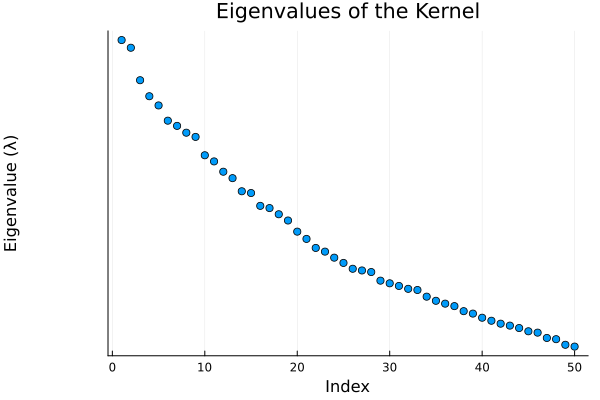

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [17]:
###############################################################################
#  A) Define the integral kernel D(r, r') via Gauss-Legendre on p ∈ [0, 1].
###############################################################################

"""
    radial_kernel(r, rp, K, m; np=20)

Approximate 
    D(r, r') = K^2 * ∫[0..1] p * J_m(K p r) * J_m(K p r') dp
using Gauss-Legendre quadrature with `np` points.
"""
function radial_kernel(r::Real, rp::Real, K::Real, m::Integer; np=20)
    # 1) Generate Gauss-Legendre nodes, weights on [0,1]
    ps, ws = gausslegendre(np) 

    # 2) Approximate the integral
    #    Integral = K^2 ∫[0..1] p * J_m(K p r) J_m(K p r') dp
    #    We'll accumulate sum( w_i * integrand( p_i ) ).
    val = 0.0
    for i in 1:np
        p = ps[i]
        w = ws[i]
        val += p * besselj(m, K*p*r) * besselj(m, K*p*rp) * w
    end

    return K^2 * val
end

###############################################################################
#  B) Build the matrix for the integral operator on r ∈ [0, R].
#     The operator is:
#         T[g](r) = ∫[0..R] D(r, r') * g(r') * r' dr'.
###############################################################################

"""
    build_operator_matrix(R, K, m, Nr; np=20)

Construct the NxN matrix M that discretizes
    (Tg)(r_j) = ∫[0..R] D(r_j, r') g(r') r' dr'.
We choose an N-point discretization of r ∈ [0, R]. 
By default, we use a simple uniform grid. You can replace it with a Gauss-Legendre grid if desired.

Returns:
- M  : the (N×N) operator matrix
- rs : vector of the radial points r_j
- dr : (if uniform) the spacing in r
"""
function build_operator_matrix(R::Real, K::Real, m::Integer, Nr::Int; np=20)
    # 1) Build a uniform grid r_j in [0, R].
    #    If you prefer Gauss-Legendre in r, see commented code below.
    rs = range(0, R, length=Nr)
    dr = R/(Nr - 1)

    # 2) Construct M
    M = Matrix{Float64}(undef, Nr, Nr)

    for j in 1:Nr
        rj = rs[j]
        for k in 1:Nr
            rk = rs[k]
            # The integrand includes D(rj, rk) * r'
            # And we approximate the integral by sum_{k} [ M[j,k] * g_k ] if g_k is g(r_k).
            Dval = radial_kernel(rj, rk, K, m; np=np) 
            # The "measure" factor for the integral in polar coordinates is r' dr'. 
            # We'll incorporate "r_k" right here. We'll incorporate "dr" outside or here.
            # A typical Riemann approach: M[j,k] = D(rj, rk) * r_k * (dr).
            M[j, k] = Dval * rk * dr
        end
    end

    return M, collect(rs), dr
end

# (Optional) If you want Gauss-Legendre in r, you can do something like:
#    rnodes, rweights = gausslegendre(Nr, 0, R)
# Then build M accordingly:
#    M[j,k] = radial_kernel(rnodes[j], rnodes[k], K, m; np=np) * rnodes[k] * rweights[k]
# so that you get a more accurate radial integration. 
# For brevity, we proceed with uniform here.

###############################################################################
#  C) Solve the eigenvalue problem:
#
#       ∫[0..R] D(r, r') g(r') r' dr' = λ g(r)
#
#    => M g = λ g   (discretized).
###############################################################################

"""
    solve_radial_eigenproblem(R, K, m, Nr; np=20, nev=5)

Build and solve the radial integral operator eigenvalue problem.
Returns the largest 'nev' eigenvalues (and the associated eigenvectors).
"""
function solve_radial_eigenproblem(R::Real, K::Real, m::Integer, Nr::Int; np=20, nev=5)
    # Build operator matrix
    M, rs, dr = build_operator_matrix(R, K, m, Nr; np=np)

    # M should be symmetric (for real K, real Bessel functions). 
    # So we can use eigen(Symmetric(M)) for a stable, real-valued decomposition.
    decomp = LinearAlgebra.eigen(LinearAlgebra.Symmetric(M))

    # By default, eigen(Symmetric(M)) returns eigenvalues in ascending order
    vals = decomp.values
    vecs = decomp.vectors

    # Let’s reverse to get the largest eigenvalues first
    idx = sortperm(vals, rev=true)
    vals_sorted = vals[idx]
    vecs_sorted = vecs[:, idx]

    # Return the top 'nev'
    nev_actual = min(nev, length(vals_sorted))
    return vals_sorted[1:nev_actual], vecs_sorted[:, 1:nev_actual], rs
end

###############################################################################
#  D) Example Usage
###############################################################################
# Choose parameters:
R   = 2.0       # radius of the circular region (example)
K   = 8.0       # wavenumber
m   = 0         # Bessel order
Nr  = 200       # number of radial points for r∈[0,R]
np  = 100        # number of quadrature points for p∈[0,1]
nev = 50         # how many eigenvalues to extract

# Solve the radial eigenvalue problem
λs, neigvecs, rgrid = solve_radial_eigenproblem(R, K, m, Nr; np=np, nev=nev)

plot(1:nev, λs, seriestype=:scatter, marker=:circle, label="", title="Eigenvalues of the Kernel",
     xlabel="Index", ylabel="Eigenvalue (λ)", grid=true)
# If you want to examine an eigenfunction g(r) in continuous sense:
#   g_i(r_j) = neigvecs[j,i]
# You can plot it vs r_j, etc.

In [18]:
using SpecialFunctions        # for Bessel functions (besselj)
using FastGaussQuadrature     # for Gauss-Legendre quadrature over p ∈ [0,1]
using LinearAlgebra           # for eigen decomposition
using Printf

###############################################################################
# 1) Define the kernel D(ξ, ξ'):
#
#    D(ξ, ξ') = 4 * N^{2D} * ∫[0..1] p * J_m(2√N^{2D} * p ξ) J_m(2√N^{2D} * p ξ') dp
#
#    We'll write a function that does the integral over p with Gauss-Legendre.
#    For m=0, J_m = J_0, but let's keep it general for possible extension.
###############################################################################
"""
    D_kernel(xi, xip, N2D, m; np=50)

Computes
    D(ξ, ξ') = 4*N^{2D} * ∫[0..1] p * J_m(2√N^{2D} p ξ) J_m(2√N^{2D} p ξ') dp
using Gauss-Legendre quadrature with `np` points on [0,1].

`m` is the Bessel order (default 0).
`N2D = (K*R)^2 / 4`.
"""
function D_kernel(xi::Real, xip::Real, N2D::Real, m::Integer; np=50)
    # 1) 2√N^{2D}
    alpha = 2*sqrt(N2D)  # = K*R

    # 2) Gauss-Legendre nodes (ps) and weights (ws) on [0, 1].
    ps, ws = gausslegendre(np)

    # 3) Accumulate integral
    val = 0.0
    for i in 1:np
        p = ps[i]
        w = ws[i]
        val += p * besselj(m, alpha * p * xi) * besselj(m, alpha * p * xip) * w
    end
    return 4*N2D * val
end

###############################################################################
# 2) Build the matrix for the integral operator T:
#
#    (Tψ)(ξ_i) ≈ ∑_j [ D(ξ_i, ξ_j) * ξ_j * Δξ ] * ψ(ξ_j).
###############################################################################
"""
    build_operator_matrix(N2D, m, N; np=50)

Create an N×N matrix M that discretizes
  (T ψ)(ξ_i) = ∫[0..1] D(ξ_i, ξ') ψ(ξ') ξ' dξ'.

We'll use a uniform grid of N points in [0,1]:
  ξ_j = (j-1)/(N-1),   j=1..N
Then (Tψ)(ξ_i) ≈ ∑_j [D(ξ_i, ξ_j)* ξ_j * Δξ] ψ(ξ_j).

Returns:
 - M: the matrix
 - xis: the array of ξ_j points
 - dξ: the uniform spacing
"""
function build_operator_matrix(N2D::Real, m::Integer, N::Int; np=50)
    # 1) Uniform grid in [0,1]
    xis = range(0.0, 1.0, length=N)
    dξ  = 1.0/(N-1)

    # 2) Create M
    M = Matrix{Float64}(undef, N, N)
    for i in 1:N
        xi = xis[i]
        for j in 1:N
            xip = xis[j]
            Dval = D_kernel(xi, xip, N2D, m; np=np)
            M[i,j] = Dval * xip * dξ
        end
    end
    return M, collect(xis), dξ
end

###############################################################################
# 3) Solve the eigenvalue problem:  M*g = λ*g.
###############################################################################
"""
    solve_eigenproblem(N2D, m, N; np=50, nev=5)

1) Construct the operator matrix M for the integral.
2) Solve M*g = λ*g.
3) Return the largest `nev` eigenvalues and eigenvectors.
"""
function solve_eigenproblem(N2D::Real, m::Integer, N::Int; np=50, nev=5)
    M, xis, dξ = build_operator_matrix(N2D, m, N; np=np)
    # We expect M to be symmetric if the kernel is real-symmetric. Use Symmetric() for numeric stability.
    decomp = eigen(Symmetric(M))
    # eigen(Symmetric(M)) returns eigenvalues sorted in ascending order. Let's reverse to get largest first.
    vals = decomp.values
    vecs = decomp.vectors
    idx = sortperm(vals, rev=true)
    vals_sorted = vals[idx]
    vecs_sorted = vecs[:, idx]

    nev_actual = min(nev, length(vals_sorted))
    return vals_sorted[1:nev_actual], vecs_sorted[:,1:nev_actual], xis
end

K   = 2.0   # Wavenumber
R   = 1.0   # Physical radius
m   = 0     # Bessel order
N   = 100   # # points in ξ-discretization
np  = 80    # # quadrature points for p∈[0,1]
nev = 5     # # of eigenvalues to report

# N^{2D} = (K*R)^2 / 4
N2D = (K*R)^2 / 4

println(">>> N^{2D} = $N2D,  alpha= K*R= $(K*R).")

# Solve
λs, evecs, xis = solve_eigenproblem(N2D, m, N; np=np, nev=nev)

# Print results
@printf("\nLargest %d eigenvalues (for m=%d):\n", length(λs), m)
for (i, λ) in enumerate(λs)
    @printf("  λ[%d] = %.6f\n", i, λ)
end

# evecs[:,i] is the discrete eigenfunction for eigenvalue λs[i].
# We can plot or analyze them further if desired.


>>> N^{2D} = 1.0,  alpha= K*R= 2.0.

Largest 5 eigenvalues (for m=0):
  λ[1] = 0.000000
  λ[2] = 0.000000
  λ[3] = 0.000000
  λ[4] = 0.000000
  λ[5] = 0.000000


  0.316145 seconds (145.87 k allocations: 51.989 MiB, 2.71% gc time, 29.40% compilation time)


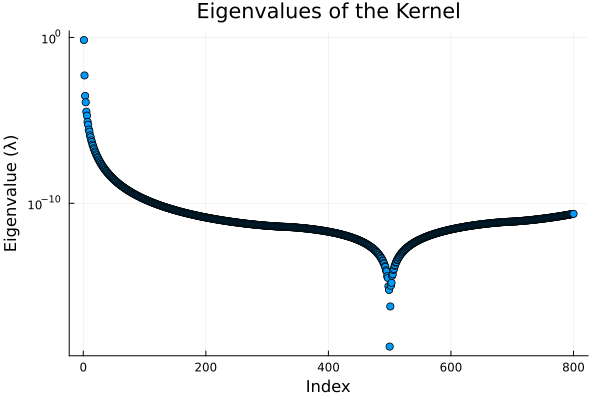

In [19]:
##############################################################################
# 1) Build the matrix M using Gauss–Legendre nodes & weights in [0,1].
##############################################################################

"""
    build_operator_matrix_gauss(N2D, m, N)

Constructs the NxN matrix M for the operator:
    (Tψ)(ξ_i) = 2√(N^2D) ∑_{j=1..N} J_m(2√(N^2D) * ξ_i * ξ_j) * ψ(ξ_j) * (ξ_j w_j).

where {ξ_j, w_j} are Gauss–Legendre nodes, weights on [0,1].
m is the Bessel function order.

Returns:
 - M   : NxN operator matrix
 - xis : array of the Gauss–Legendre nodes ξ_j
 - ws  : array of the Gauss–Legendre weights w_j
"""
function build_operator_matrix_gauss(N2D::Float64, m::Integer, N::Int)
    # 1) Gauss–Legendre nodes & weights on [0,1]
    #    FastGaussQuadrature.gausslegendre(N, 0, 1)
    #    returns nodes in (0,1) and corresponding weights.
    xis, ws = gausslegendre(N)

    alpha = 2*sqrt(N2D)  # factor

    # 2) Construct matrix M: M[i,j] = alpha * besselj(m, alpha * ξ_i * ξ_j) * (ξ_j * w_j)
    M = Matrix{Float64}(undef, N, N)
    for i in 1:N
        xi = xis[i]
        for j in 1:N
            xj = xis[j]
            M[i,j] = alpha * besselj(m, alpha*xi*xj) * (xj * ws[j])
        end
    end

    return M, xis, ws
end

##############################################################################
# 2) Solve the eigenvalue problem: M*g = μ*g => λ = μ^2
##############################################################################

"""
    solve_eigenproblem_gauss(N2D, m, N; nev=5)

Build and solve the integral-operator matrix using Gauss–Legendre quadrature.
M*g = μ*g => μ = sqrt(λ).

Returns:
  mus[1:nev], lambdas[1:nev], evecs[:,1:nev], xis, ws
"""
function solve_eigenproblem_gauss(N2D::Float64, m::Integer, N::Int; nev=5)
    M, xis, ws = build_operator_matrix_gauss(N2D, m, N)

    # M should be real symmetric => use eigen(Symmetric(M))
    decomp = eigen(Symmetric(M))

    # eigen() typically gives ascending order => reverse to get largest first
    vals_all = decomp.values
    vecs_all = decomp.vectors
    idx = sortperm(vals_all, rev=true)
    mus_all = vals_all[idx]               # μ_i
    evecs_all = vecs_all[:,idx]

    # Then λ_i = μ_i^2
    lambdas_all = [μ^2 for μ in mus_all]

    nret = min(nev, length(mus_all))
    return (mus_all[1:nret],
            lambdas_all[1:nret],
            evecs_all[:,1:nret],
            xis,
            ws)
end


N2D = (K*R)^2 / (4*pi)    # e.g. (K*R)^2 / 4 if K*R=2 => N2D=1
m   = 0      # Bessel order
N   = 1000     # number of Gauss–Legendre nodes
nev = 800      # number of eigenvalues to compute

@time mus, lambdas, evecs, xis, ws = solve_eigenproblem_gauss(N2D, m, N; nev=nev)

plot(1:nev, lambdas; yscale = :log10,seriestype = :scatter, marker = :circle,label = "",title = "Eigenvalues of the Kernel",xlabel = "Index",ylabel = "Eigenvalue (λ)",grid = true)
# evecs[:,i] gives the discrete eigenfunction for μ[i].
#   => M*g_i = μ[i]*g_i => T*g_i = μ[i]*g_i
# Then λ[i] = μ[i]^2.
